### Import of Libraries
We will import all the required libraries for deep learning technique.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D


TensorFlow Version: 2.8.2


### Import of Data
We will import the data from the following link. There is no need to import a path.

In [2]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Alz_data.zip"
!unzip -qo Alz_data.zip 
!rm Alz_data.zip

--2022-07-09 02:43:20--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Alz_data.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.158.51
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.158.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35524854 (34M) [application/x-zip-compressed]
Saving to: ‘Alz_data.zip’

Alz_data.zip        100%[===================>]  33.88M  7.68MB/s    in 4.4s    

2022-07-09 02:43:25 (7.68 MB/s) - ‘Alz_data.zip’ saved [35524854/35524854]



### Pre-Processing Data

In [3]:
#let us define directories to store our data

default_dir = "/content/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = default_dir + "test/"
train_dir = default_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']


### Data Augmentation
We will transform our data with the help of different parameters

In [4]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [5]:
#data augmentation params
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


### Data Visualization
Let us look into random images to get an idea of different types.

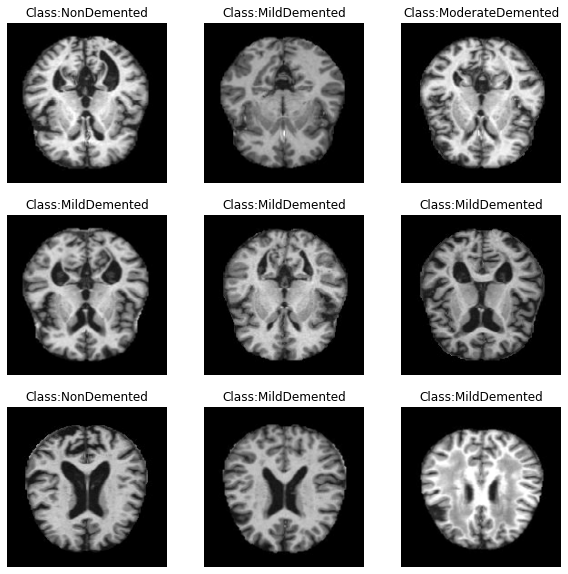

In [6]:
def show_images(generator,y_pred=None):
    """
   This function will display random images to get an idea of different types of images
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a lot of images
    x,y = generator.next()
    
    # show a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Image visualization
show_images(train_data_gen)

In [7]:
#Let us generate data from train set

train_data, train_labels = train_data_gen.next()

In [8]:
#dimension of data and labels
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


### Data Balancing
The data in all the classes are not same. So we will perform SMOTE technique to balance all the data SMOTE will create some synthetiic points to the minor samples.

In [10]:
#implementation of SMOTE
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


### Data Splitting
We will split the data where 80% of data will be trained and 20% of data will be tested.

In [11]:
#splitting data into train, test and validation
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Model Building
We will define different layers such as convolutional layers, dense and pooling layers of our CNN model

In [12]:
def conv_block(filters, act='relu'):
    """This function will implement convoluution layers in our model """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [13]:
def dense_block(units, dropout_rate, act='relu'):
    """This function will implement dense layers in our model  """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [14]:
def construct_model(act='relu'):
    """This function will join all the layers for final model """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

In [15]:
#compile the model with optimizer and loss function
model = construct_model()
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),metrics=["accuracy"])

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 16)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                         

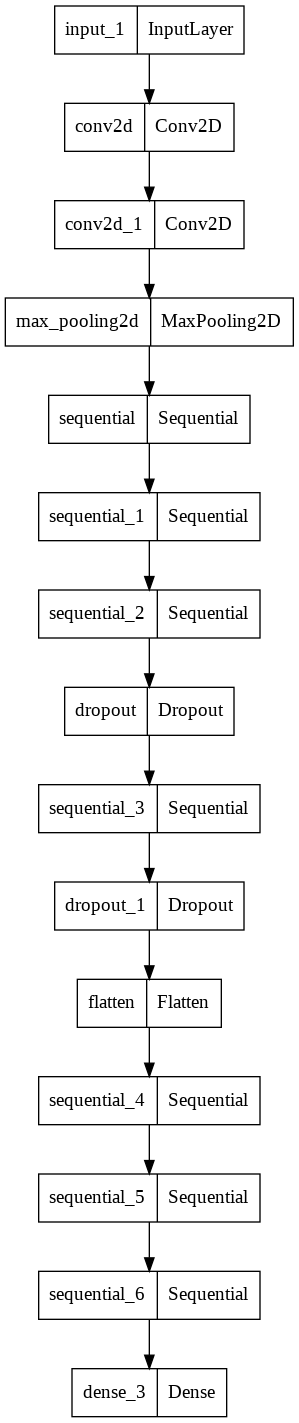

In [17]:
plot_model(model) #model architecture

### Training the model
We will train the model with 50 epochs and validate the model on validation data

In [ ]:
#model training
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels),epochs=EPOCHS)

Epoch 1/50
256/256 [==============================] - 9s 36ms/step - loss: 0.7008 - accuracy: 0.6763 - val_loss: 0.6245 - val_accuracy: 0.7090
Epoch 2/50
256/256 [==============================] - 9s 34ms/step - loss: 0.6598 - accuracy: 0.6968 - val_loss: 2.4292 - val_accuracy: 0.3022
Epoch 3/50
256/256 [==============================] - 9s 34ms/step - loss: 0.6330 - accuracy: 0.7125 - val_loss: 3.4360 - val_accuracy: 0.2417
Epoch 4/50
256/256 [==============================] - 9s 34ms/step - loss: 0.5602 - accuracy: 0.7467 - val_loss: 0.9853 - val_accuracy: 0.6040
Epoch 5/50
256/256 [==============================] - 9s 34ms/step - loss: 0.5449 - accuracy: 0.7600 - val_loss: 0.4901 - val_accuracy: 0.7671
Epoch 6/50
256/256 [==============================] - 9s 34ms/step - loss: 0.5047 - accuracy: 0.7780 - val_loss: 4.4693 - val_accuracy: 0.3472
Epoch 7/50
256/256 [==============================] - 9s 34ms/step - loss: 0.4900 - accuracy: 0.7891 - val_loss: 0.7547 - val_accuracy: 0.7007

### Model Plots
These plots will give us an idea about the accuracy and losses obtained in different epochs

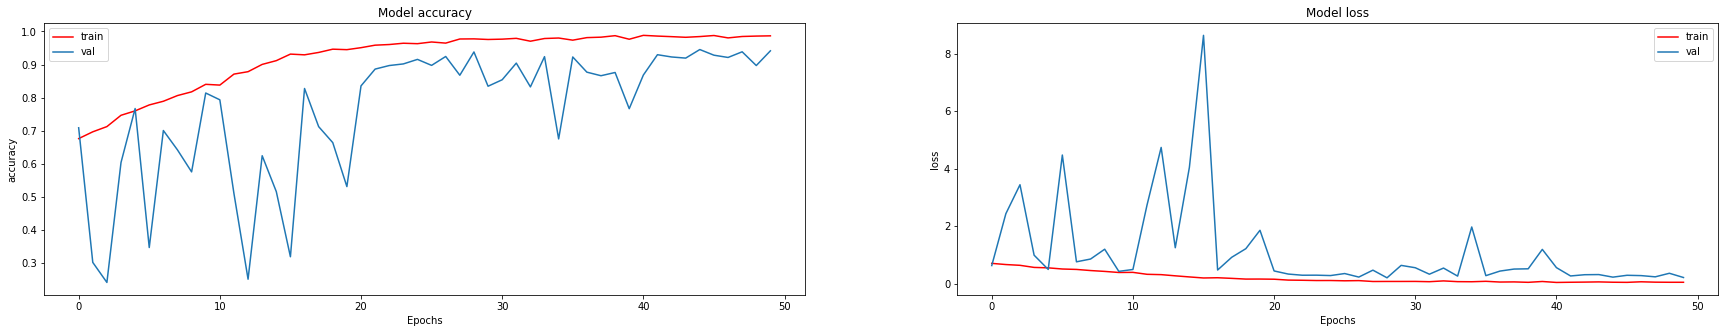

In [ ]:
#model accuracy and losses
fig, ax = plt.subplots(1, 2, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["accuracy",  "loss"]):
    ax[i].plot(history.history[metric],color="r")
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
#model evalaution on test data
test_scores = model.evaluate(test_data, test_labels)

print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 1s 11ms/step - loss: 0.2198 - accuracy: 0.9371
Test Accuracy: 93.71%


In [ ]:
#prediction of classes
pred_labels = model.predict(test_data)

### Model Evalaution
We will evaluate the model using confusion matrix and classifiction report

In [ ]:
#function of confusion matrix
def roundoff(arr):
    """defining confusion matrix"""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.98      0.96      0.97       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.91      0.89      0.90       662
ModerateDemented       0.87      0.90      0.88       624

       micro avg       0.94      0.94      0.94      2560
       macro avg       0.94      0.94      0.94      2560
    weighted avg       0.94      0.94      0.94      2560
     samples avg       0.94      0.94      0.94      2560



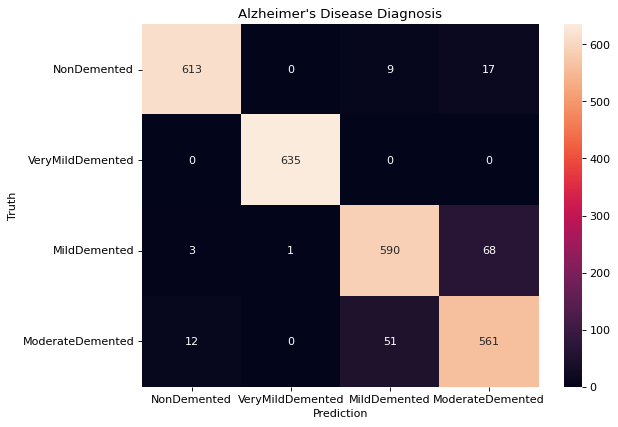

In [ ]:
#confusion matrix
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
#balanced accuracy and mathews correlation coefficient

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("MCC: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 93.74 %
MCC: 91.62 %
